In [1]:
# One-stroke Kolam Plotting - Given a Gate Matrix 240702
# Also converts a hex string to a integer vector with vocabulary 0-15 for use in one-hot generative tasks
%matplotlib notebook

import sys
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from datetime import datetime
import tensorflow as tf

import matplotlib.animation as animation

from PIL import Image

np.random.seed(seed=1)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [3]:
def gmtostr (GM):
    # Converts a kolam gate matrix to a binary string, an intermediate step towards converting to an hex string
    GM = np.int16(GM)
    GMs = ""
    for i in range (np.shape(GM)[0]):
        for j in range (np.shape(GM)[1]):
            GMs = GMs + str(GM[i,j])
    return GMs

def strtogm (string):
    # Converts a binary string to a kolam gate matrix
    Ndim = np.int16(np.sqrt(len(string)))
    GMr = np.zeros((Ndim, Ndim))
    for i in range (Ndim):
        for j in range (Ndim):
            GMr[i,j] = int(string[j+i*Ndim], 16)
    return GMr

def bstr2hstr (bstring):
    # Converts a binary string to an hex string
    if np.mod (len(bstring), 4) !=  0:
        bstring = bstring + ""
        bstring = bstring + ""
    Nhex = np.int16(len(bstring)/4)
    hstring = ""
    #GMhex = []
    for i in range (Nhex):
        stringx = bstring[(i*4):(i+1)*4]
        stringx = int(stringx, 2)
        stringx = format(stringx, 'x')
        #GMhex.append(stringx)
        hstring = hstring + stringx
    return hstring

def hstr2bstr (hstring):
    # Converts an hex string to a binary string
    #Nbin = np.int16(len(hstring)*4)
    bstring = ""
    for i in range (len(hstring)):
        stringx = bin(int(hstring[i], 16))[2:]
        #print (stringx)
        if len(stringx) < 4:
            for j in range (4-len(stringx)):
                stringx = '0' + stringx
        bstring = bstring + stringx
    return bstring

def hstr2ivec (hstring):
    # Converts an hex string to an integer vector with vocabulary 0-15 - for use in a one-hot generative tasks
    Nlen = len (hstring)
    ivec = np.zeros(Nlen)
    for i in range (Nlen):
        ivec[i] = int(hstring[i], 16)
    return np.int16(ivec)

def ivec2hstr (ivec):
    # Converts an integer vector with vocabulary 0-15 to an hex string
    hstr = ""
    for i in range (len(ivec)):
        hvec = hex(ivec[i])
        hvec = str(hvec)[-1]
        hstr = hstr + hvec
    return hstr

def GenericNextStep(GM, icg,jcg,ce):

    ND = np.shape(GM)[0] - 1
    icgx = icg + ND
    jcx = jcg + ND
    icgx2 = int(np.floor(icgx/2))
    jcx2 = int(np.floor(jcx/2))
    #print(ND, icgx2, jcx2)

    calpha = np.mod(ce,2)
    if ce>1:
        cbeta = -1
    else:
        cbeta = 1
    if np.mod(int(icgx + jcx),4) == 0:
        cgamma = -1
    else:
        cgamma = 1

    if GM[icgx2,jcx2]>0.5:
        cg = 1
    else:
        cg = 0

    cgd = 1-cg
    calphad = 1-calpha
    nalpha = cg*calpha + cgd*calphad
    nbeta = (cg + cgd*cgamma)*cbeta
    nh = (calphad*cgamma*cgd + calpha*cg)*cbeta
    nv = (calpha*cgamma*cgd + calphad*cg)*cbeta
    ing = int(icg + nh*2)
    jng = int(jcg + nv*2)
    ingp = icg + cgd*(calphad*cgamma - calpha)*cbeta*0.5
    jngp = jcg + cgd*(calpha*cgamma - calphad)*cbeta*0.5
    if nalpha == 0:
        if nbeta == 1:
            ne = 0
        else:
            ne = 2
    if nalpha == 1:
        if nbeta == 1:
            ne = 1
        else:
            ne = 3

    return(ing,jng,ne,ingp,jngp, icgx2, jcx2)

def GenericXNextSteps(GM, icgo,jcgo,ceo,Ns):

    ijcx = np.zeros((Ns,2))
    ijcgx2 = np.zeros((Ns,2))
    cex = np.zeros((Ns))
    ijcp = np.zeros((Ns,2))
    ijcx[0,:] = [icgo,jcgo]
    cex[0] = ceo
    for i in range(Ns-1):
        ijcx[i+1,0], ijcx[i+1,1], cex[i+1], ijcp[i,0], ijcp[i,1], ijcgx2[i,0], ijcgx2[i,1] = GenericNextStep(
            GM, ijcx[i,0], ijcx[i,1], cex[i])
    return (ijcx, cex, ijcp, ijcgx2)

def rotatekolam (ij):
    ijx = (ij[:,0] + ij[:,1])/2
    ijy = (ij[:,0] - ij[:,1])/2
    return ijx, ijy

def plotkolam (ijngp, ND):
    Ncx = np.shape (ijngp)[0] - 5
    fig, ax = plt.subplots(figsize = (5,5))

    ijx, ijy = rotatekolam (ijngp)
    ax.plot(ijx[0:Ncx+1], ijy[0:Ncx+1] , '0.5', antialiased=True)

    Mn = -(ND+1)
    Mx = ND+1
    plt.axis('off')
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.xlim(Mn,Mx)
    plt.ylim(Mn,Mx)
    plt.show()
    
def plotkolams (ij, ND, Nrows):
    fig = plt.subplots(figsize = (8,60))
    Ncx = np.shape (ij)[1] - 5
    Ncols = np.int16 (np.shape(ij)[0]/Nrows)
    for i in range(np.shape(ij)[0]):
        plt.subplot(Nrows, Ncols, i+1)
        ijx, ijy = rotatekolam (ij[i])
        #print (np.shape(ijx), np.shape(ijy))
        plt.plot(ijx[0:Ncx+1], ijy[0:Ncx+1] , 'r', markersize = '0.2')
        plt.axis('off')

        
def plotnsavekolam (ijngp, ND, filename):
    Ncx = np.shape (ijngp)[0] - 5
    fig, ax = plt.subplots(figsize = (5,5))
    fig.tight_layout()
    ijx, ijy = rotatekolam (ijngp)
    ax.plot(ijx[0:Ncx+1], ijy[0:Ncx+1] , '0.5', linestyle = '-')

    Mn = -(ND+1)
    Mx = ND+1
    plt.axis('off')
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.xlim(Mn,Mx)
    plt.ylim(Mn,Mx)
    plt.savefig(filename)

In [4]:
# Read Data
with open('kolam19hexGH.txt', 'r+') as f:
    khstr = f.read()
khstr = khstr.splitlines()

In [5]:
print (len(khstr))

10


In [6]:
print (khstr[0])

000007dd767dcde7addc7dbbe6fef216fee6d6fc7e95a776f00f6ee5a97e3f6b677f684f7f67ddbe3bb5e7b3be6ebbe00000


In [7]:
str(10)

'10'

In [8]:
import csv

<IPython.core.display.Javascript object>


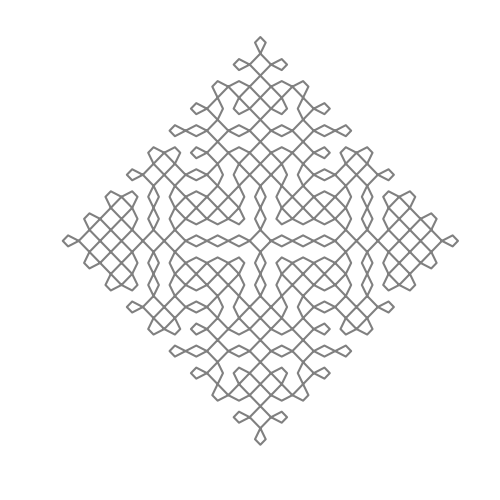

<IPython.core.display.Javascript object>


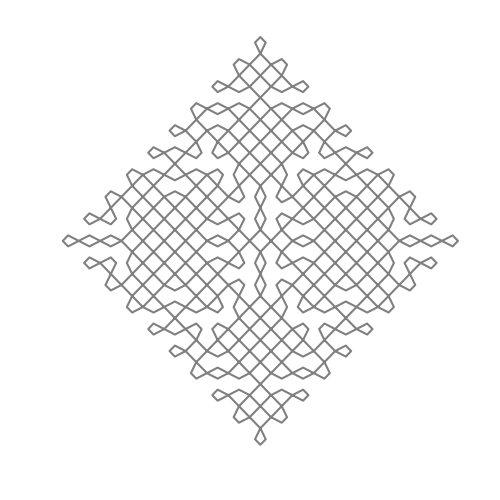

<IPython.core.display.Javascript object>


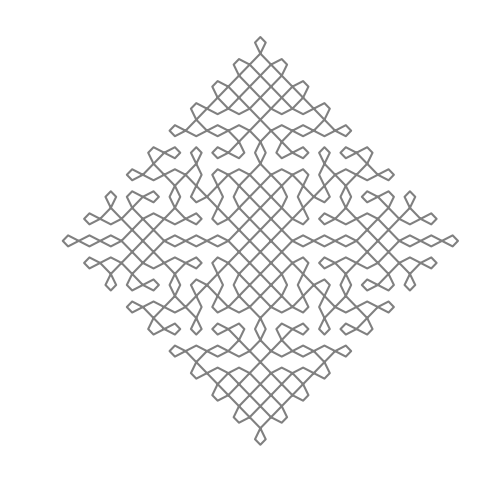

<IPython.core.display.Javascript object>


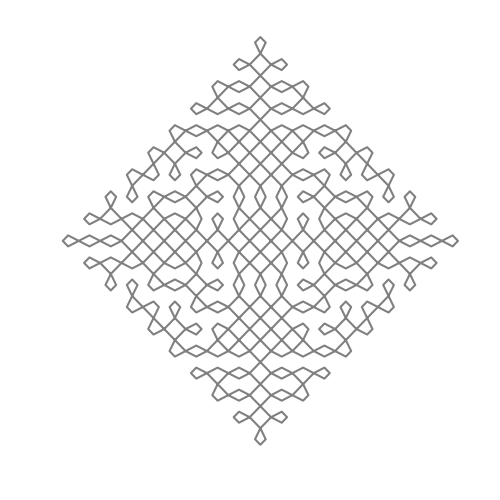

<IPython.core.display.Javascript object>


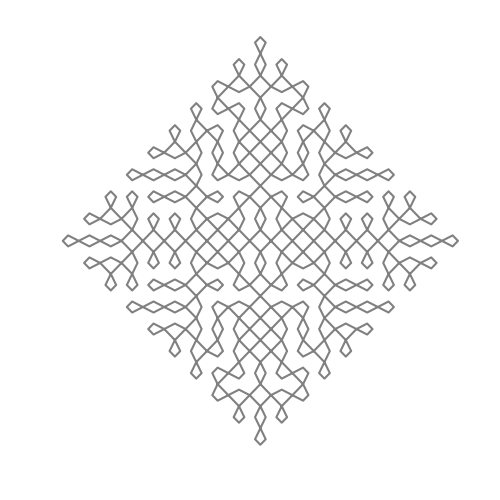

<IPython.core.display.Javascript object>


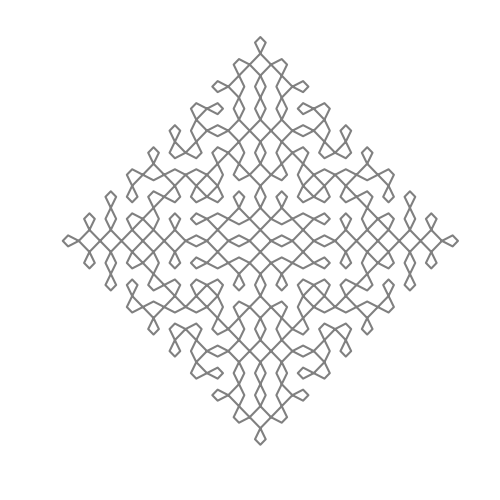

<IPython.core.display.Javascript object>


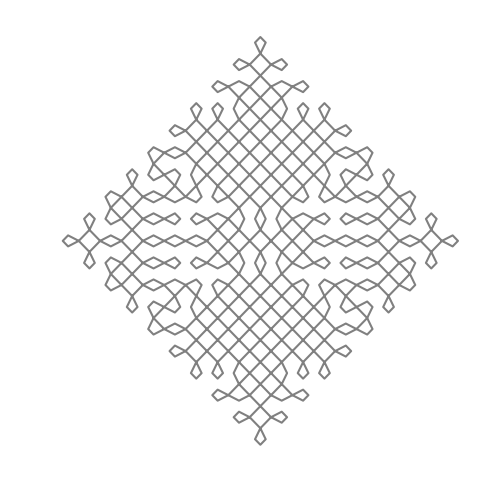

<IPython.core.display.Javascript object>


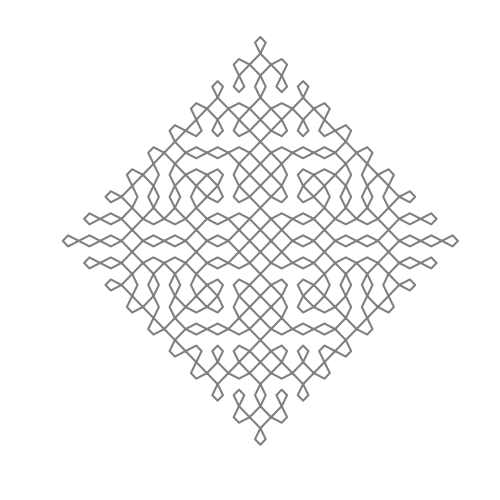

<IPython.core.display.Javascript object>


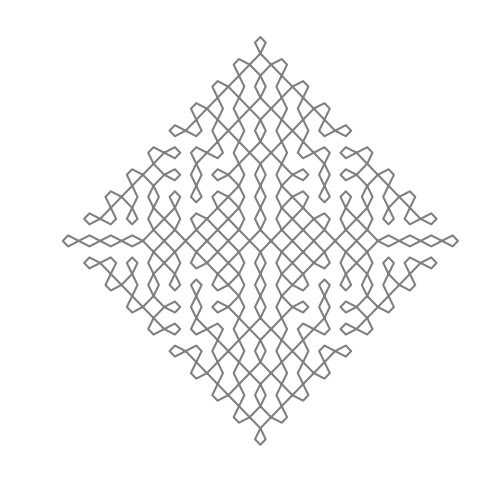

<IPython.core.display.Javascript object>


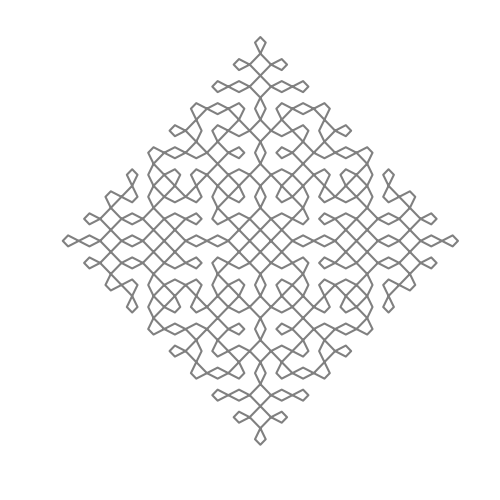

(10, 729, 2)


In [9]:
ND = 19
Ns = 2*(ND**2 + 1) + 5
Ncx = Ns-5
icgo = 1
jcgo = 1
ceo = 1
Nk = len(khstr)
ijngp = np.zeros ((Nk, Ns, 2))
ijxy = np.zeros ((Ns, Nk, 2))
for i in range (Nk):
    GMk = hstr2bstr (khstr[i])
    #print (GMk)
    GMk = strtogm (GMk)
    #print (GMk)
    ijng,ne,ijngp[i],_ = GenericXNextSteps(GMk,icgo,jcgo,ceo,Ns)
    ijxy[:,i,0], ijxy[:,i,1] = rotatekolam (ijngp[i])
    #print (ijngp[i])
    #plotkolam (ijngp[i], ND)
    plotnsavekolam (ijngp[i], ND, "kolam19DSkr1" + str(i) + ".jpg")
    
ijxy = tf.reshape (ijxy, (Ns, 2*Nk))
ijxy = tf.slice (ijxy, [0, 0], [Ncx+1, 2*Nk])
print (np.shape(ijngp))

#plotkolams (ijngp, ND, 50)

In [90]:
np.savetxt ("kolam19DSkr1.txt", ijxy)

In [91]:
# Open the CSV file in append mode
with open('kolam19DSkr1.csv', 'a', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the data to the CSV file
    writer.writerows(np.array(ijxy))

# Close the file
csvfile.close()

In [68]:
np.shape(ijxy)

TensorShape([725, 800])

In [20]:
Ns

585

In [ ]:
# Converting a hex string into a integer vector using hstr2ivec for one-hot generative tasks - work in progress

In [33]:
ijngp = ijngp[0]

<IPython.core.display.Javascript object>


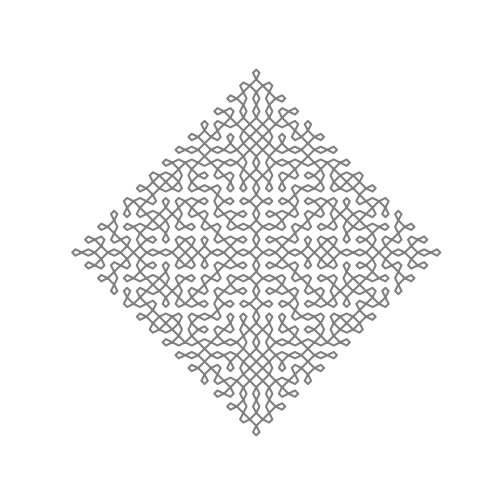

(-30.0, 30.0)

In [43]:
Ncx = np.shape (ijngp)[0] - 5

fig, ax = plt.subplots(figsize = (5,5))
#fig.tight_layout()
ijx, ijy = rotatekolam (ijngp)
ax.plot(ijx[0:Ncx+1], ijy[0:Ncx+1] , '0.5', linestyle = '-')

Mn = -(ND+1)
Mx = ND+1
plt.axis('off')
plt.xticks(color='w')
plt.yticks(color='w')
plt.xlim(Mn,Mx)
plt.ylim(Mn,Mx)

In [53]:
# Import a Gate marix & draw kolam
GM = np.loadtxt ("GM7.txt")

In [56]:
GM[1,1] = GM[6,6] = GM[1,6] = GM[6,1] = 1
#GM[3,1] = GM[1,3] = 0
#GM[6,8] = GM[8,6] = 0

In [57]:
print (GM)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 0.]
 [0. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


icgo 3


<IPython.core.display.Javascript object>


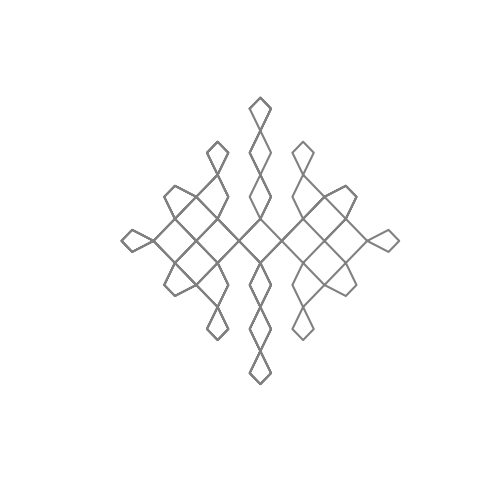

icgo 5


<IPython.core.display.Javascript object>


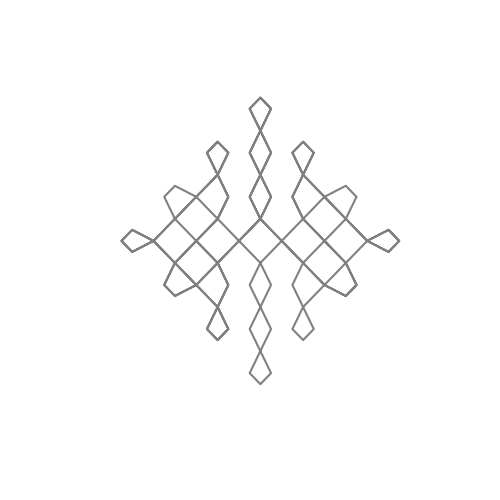

icgo 7


<IPython.core.display.Javascript object>


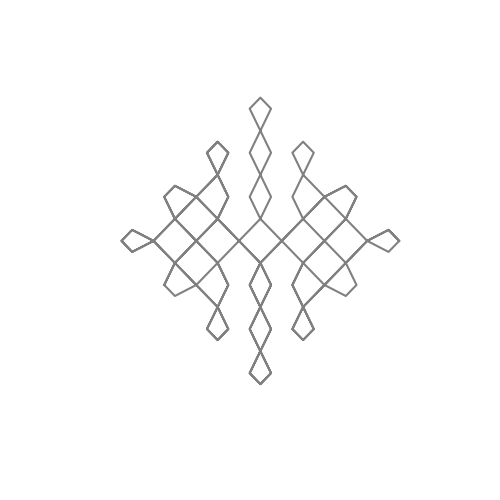

(3, 169, 2)


In [58]:
ND = 9
Ns = 2*(ND**2 + 1) + 5
Ncx = Ns-5
icgo = 5
jcgo = 5
ceo = 1
Nk = 3
ijngp = np.zeros ((Nk, Ns, 2))
ijxy = np.zeros ((Ns, Nk, 2))
for i in range (Nk):
    #icgo = jcgo = -2*np.random.randint(1,5)+1
    icgo = jcgo = 2*i + 3
    print ('icgo', icgo)

    #print (GMk)
    ijng,ne,ijngp[i],_ = GenericXNextSteps(GM,icgo,jcgo,ceo,Ns)
    ijxy[:,i,0], ijxy[:,i,1] = rotatekolam (ijngp[i])
    #print (ijngp[i])
    #plotkolam (ijngp[i], ND)
    plotnsavekolam (ijngp[i], ND, "kolam59p7s.jpg")
    
ijxy = tf.reshape (ijxy, (Ns, 2*Nk))
ijxy = tf.slice (ijxy, [0, 0], [Ncx+1, 2*Nk])
print (np.shape(ijngp))
